In [1]:
#####
##### Prework
#####

In [2]:
##### Import module

### Data
import numpy as np
import pandas as pd
import os
import glob
import datetime
import matplotlib.pyplot as plt
import datetime
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition

### ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
##### Memo

memo = '2008 DP-01-RightStrait_SingleCliffPCA20'

In [4]:
##### Functions

def time_tag(input_dt, type=1):
    # Ref: 10 T-09
    # Ver: 1.1
    # Input: datetime.datetime
    # Output: str tags ('YYMMDD_hhmm', 'YYYY/MM/DD hh:mm')
    dt_now = input_dt
    YYYY = str(dt_now.year)
    YY = str(dt_now.year)[-2:]
    MM = str(dt_now.month).zfill(2)
    DD = str(dt_now.day).zfill(2)
    hh = str(dt_now.hour).zfill(2)
    mm = str(dt_now.minute).zfill(2)
    if type == 2:
        tag = YYYY + '/' + MM + '/' + DD + ' ' + hh + ':' + mm
    else:
        tag = YY + MM + DD + '_' + hh + mm
    return tag

In [5]:
##### Parameters

### Output info
time_tag = time_tag(datetime.datetime.now(), type=1)
output_fol = f'output/{time_tag}_{memo}'
os.makedirs(output_fol)
print(f'Time tag: {time_tag}')

### Model
model_name = ''
NUM_neuron = [64, 32, 32]
ACTIVATION_func = ['relu']
l1_ratio = 1e-4
l2_ratio = 1e-4
kernel_reg = [l1(l1_ratio)]
OPTI_lr = 0.0001

### Compile
comp_opti = keras.optimizers.Adam(lr=OPTI_lr)
comp_loss = keras.losses.MeanSquaredError()

###
number_epochs = 5000

Time tag: 210816_0102


In [6]:
##### Prework

NUM_layer = len(NUM_neuron)

layer_di = {}
if len(ACTIVATION_func) == 1: ACTIVATION_func *= len(NUM_neuron)
if len(kernel_reg) == 1: kernel_reg *= len(NUM_neuron)
for i in range(len(NUM_neuron)):
    layer_di[i] = [NUM_neuron[i], ACTIVATION_func[i], kernel_reg[i]]

In [7]:
##### Callback

# https://keras.io/api/callbacks/early_stopping/
# https://keras.io/api/callbacks/model_checkpoint/
# https://keras.io/api/callbacks/reduce_lr_on_plateau/

earlystop = EarlyStopping(monitor='val_loss',
                          patience=1000, 
                          verbose=1
                          )

model_ckpt = ModelCheckpoint(filepath=os.path.join(output_fol, f'{time_tag}_model.h5'),
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=0
                            )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              min_lr=1e-12,
                              patience=500,
                              verbose=1
                             )

In [8]:
CALLBACKS_li = [
                earlystop,
                model_ckpt,
                reduce_lr,
               ]

In [9]:
##### Path and load

path_train = './database/train.csv'
path_test  = './database/test.csv'
train_df   = pd.read_csv(path_train).set_index('id')
test_df    = pd.read_csv(path_test).set_index('id')

In [10]:
print(f'Length of train_df: {len(train_df)}')
train_df.head()

Length of train_df: 250000


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
id,,,,,,,,,,,,,,,,,,,,,
0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,1.09101,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,1.28138,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,1.24210,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,1.09130,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,1.10151,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197,1


In [11]:
print(f'Length of test_df: {len(test_df)}')
test_df.head()

Length of test_df: 150000


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,
250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.04360,0.942256,29.898000,1.11394,...,0.446389,-422.332,-1.44630,1.69075,1.059300,-3.010570,1.94664,0.529470,1.386950,8.78767
250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.80500,0.807194,38.421900,1.09695,...,0.377179,10352.200,21.06270,1.84351,0.251895,4.440570,1.90309,0.248534,0.863881,11.79390
250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.24000,-0.003300,37.940000,1.15222,...,0.990140,3224.020,-2.25287,1.55100,-0.559157,17.838600,1.83385,0.931796,2.336870,9.05400
250003,0.860985,19,-0.549509,0.471799,7501.6000,2.80698,71.08170,0.792136,0.395235,1.20157,...,1.396880,9689.760,14.77150,1.41390,0.329272,0.802437,2.23251,0.893348,1.359470,4.84833
250004,0.313229,89,0.588509,0.167705,2931.2600,4.34986,1.57187,1.118300,7.754630,1.16807,...,0.862502,2693.350,44.18050,1.58020,-0.191021,26.253000,2.68238,0.361923,1.532800,3.70660


In [12]:
##### Try PCA: merge single cliff

In [13]:
PCA_axes = 20

In [14]:
### Pickup single cliff

path_sc_li = glob.glob('F:/py_workspace/Kaggle/Tabular Playground Series - 202108/output/hist/single cliff/*.png')
col_name_sc_li = [os.path.basename(x).split('.')[0].split('_')[1] for x in path_sc_li]
print(len(col_name_sc_li))
print(col_name_sc_li)

47
['f10', 'f13', 'f15', 'f17', 'f23', 'f25', 'f29', 'f30', 'f31', 'f33', 'f35', 'f36', 'f39', 'f4', 'f40', 'f41', 'f42', 'f44', 'f46', 'f49', 'f53', 'f54', 'f59', 'f6', 'f61', 'f62', 'f63', 'f64', 'f66', 'f68', 'f71', 'f72', 'f74', 'f78', 'f79', 'f8', 'f82', 'f83', 'f87', 'f88', 'f89', 'f9', 'f90', 'f92', 'f95', 'f96', 'f97']


In [15]:
### col_name before after

merge_li = col_name_sc_li
PCA_axis_li = [f'PCA_{x}' for x in range(PCA_axes)]
print(PCA_axis_li)

['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19']


In [16]:
### PCA applied

pca = decomposition.PCA(n_components=PCA_axes)
pca.fit(train_df[merge_li])
trans_train = pca.transform(train_df[merge_li])

In [17]:
### PCA result

print(np.shape(trans_train))
trans_train

(250000, 20)


array([[-3.55285418e+03, -1.84560486e+02, -1.26791129e+02, ...,
         1.76049170e-01, -2.17860477e+00, -4.43594153e-01],
       [ 2.37297665e+04, -1.62916612e+02, -1.90298299e+00, ...,
         6.51070362e+00, -1.15218921e+00, -5.47027188e+00],
       [-2.21183919e+03,  1.78366406e+01, -1.34322848e+02, ...,
        -1.03756316e+00,  5.67045894e-01, -6.49259532e-01],
       ...,
       [-1.53224915e+03, -1.74129258e+02, -1.46661130e+02, ...,
        -2.28934910e+00,  2.18956527e-01, -9.44374105e-01],
       [ 1.14598879e+03,  6.03355353e+02, -1.84294053e+02, ...,
        -4.16490121e+00,  3.38074902e+00, -9.90473317e-01],
       [-3.39770373e+03, -1.70087007e+02, -1.14171628e+02, ...,
         4.51868090e+00,  3.63358654e+00,  5.17783750e-01]])

In [18]:
### Swap dataframe content

train_df = train_df.drop(merge_li, axis=1)
for i in range(PCA_axes):
    train_df[PCA_axis_li[i]] = trans_train[:, i]

In [19]:
### same on test dataframe

trans_test = pca.transform(test_df[merge_li])
print(np.shape(trans_test))
#trans_mx_test

test_df = test_df.drop(merge_li, axis=1)
for i in range(PCA_axes):
    test_df[PCA_axis_li[i]] = trans_test[:, i]

(150000, 20)


In [20]:
##### col_name collect

feature_col_li = list(test_df.columns)
target_col_li  = sorted(list(set(list(train_df.columns)) - set(list(test_df.columns))))

print(feature_col_li)
print(target_col_li)

['f0', 'f1', 'f2', 'f3', 'f5', 'f7', 'f11', 'f12', 'f14', 'f16', 'f18', 'f19', 'f20', 'f21', 'f22', 'f24', 'f26', 'f27', 'f28', 'f32', 'f34', 'f37', 'f38', 'f43', 'f45', 'f47', 'f48', 'f50', 'f51', 'f52', 'f55', 'f56', 'f57', 'f58', 'f60', 'f65', 'f67', 'f69', 'f70', 'f73', 'f75', 'f76', 'f77', 'f80', 'f81', 'f84', 'f85', 'f86', 'f91', 'f93', 'f94', 'f98', 'f99', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19']
['loss']


In [21]:
##### Scaler: Minmax

scaler = MinMaxScaler()
train_feature_mx = train_df[feature_col_li].to_numpy()
scaler.fit(train_feature_mx)
print(scaler.data_max_)

[1.07207000e+00 2.73000000e+02 9.76859000e+00 1.68019000e+00
 3.50780000e+01 4.01038000e+00 2.18142000e+00 1.73854000e+02
 9.72759000e+00 3.34601550e+07 3.24253000e+00 4.58125000e+00
 1.15127000e+00 2.94081000e+01 4.54326000e+04 1.79559000e+00
 1.73770000e+02 9.21860000e+04 3.99534000e+01 1.69191000e+00
 1.73425000e+02 6.14419000e+00 6.94478000e+00 8.50681000e-01
 6.47330000e+02 2.09926000e+01 1.90794000e+00 5.41388000e+00
 2.63111000e+00 2.00631000e+05 5.29600000e+03 4.89972000e+04
 4.58957000e+00 1.37923000e+02 1.24170000e+10 1.07613000e+00
 2.63892000e+00 1.83704000e+01 1.96087000e+02 4.36636000e+00
 4.83344000e+04 2.85491000e+00 5.10900000e+01 5.61672000e+00
 2.49145000e-01 8.50775000e+00 1.04136000e+01 1.12100000e+03
 5.43346000e+04 5.40302000e+00 1.94419000e+00 4.49262000e+00
 3.40192000e+01 3.42523456e+04 8.74564164e+02 7.88914239e+02
 5.36027263e+02 5.13981885e+02 4.25458991e+02 1.25746461e+02
 1.05623958e+02 7.66079533e+01 5.77854228e+01 6.43516937e+01
 4.60617528e+01 4.170725

In [22]:
train_df[feature_col_li] = scaler.transform(train_df[feature_col_li])
test_df[feature_col_li] = scaler.transform(test_df[feature_col_li])

In [23]:
##### Seperate x and y

x_train_df = train_df[feature_col_li].copy()
y_train_df = train_df[target_col_li].copy()
x_test_df  = test_df[feature_col_li].copy()

In [24]:
x_train_df

,f0,f1,f2,f3,f5,f7,f11,f12,f14,f16,...,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
id,,,,,,,,,,,,,,,,,,,,,
0,0.058636,0.262069,0.490389,0.039642,0.520648,0.663569,0.924067,0.139886,0.524289,0.149490,...,0.308526,0.389165,0.380392,0.501531,0.243498,0.200402,0.563689,0.396787,0.267689,0.402298
1,0.748009,0.558621,0.420724,0.299497,0.176353,0.609690,0.329002,0.753923,0.549080,0.714358,...,0.168083,0.254739,0.339565,0.442269,0.080317,0.327973,0.396917,0.609556,0.301215,0.217610
2,0.339152,0.124138,0.422494,0.346325,0.599544,0.444931,0.222364,0.159713,0.551666,0.040679,...,0.127672,0.390615,0.380067,0.437073,0.259884,0.216138,0.587288,0.356024,0.357370,0.394741
3,0.245348,0.117241,0.412084,0.767463,0.192171,0.677797,0.140188,0.264186,0.302373,0.066962,...,0.173125,0.392616,0.214233,0.310091,0.237860,0.312671,0.538442,0.331868,0.344702,0.299305
4,0.445917,0.127586,0.501790,0.438252,0.406514,0.479443,0.324726,0.594514,0.523147,0.590345,...,0.134331,0.462286,0.393280,0.741265,0.533994,0.115081,0.552288,0.217991,0.350655,0.467947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.870249,0.079310,0.484528,0.450112,0.118774,0.612679,0.588349,0.216914,0.545603,0.457727,...,0.172693,0.271703,0.442666,0.586398,0.205667,0.153595,0.381969,0.574381,0.266683,0.368808
249996,0.274089,0.082759,0.415447,0.890131,0.544036,0.360378,0.676551,0.212581,0.532136,0.507014,...,0.114150,0.255451,0.451548,0.406573,0.215384,0.312228,0.588121,0.458884,0.413288,0.404960
249997,0.101018,0.241379,0.473186,0.690674,0.465809,0.445611,0.174199,0.755550,0.528564,0.080586,...,0.115956,0.306912,0.783394,0.754562,0.117757,0.240120,0.329048,0.313979,0.346000,0.383898


In [25]:
y_train_df

,loss
id,
0,15
1,3
2,6
3,2
4,1
...,...
249995,11
249996,5
249997,1


In [26]:
x_test_df

,f0,f1,f2,f3,f5,f7,f11,f12,f14,f16,...,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
id,,,,,,,,,,,,,,,,,,,,,
250000,0.772720,0.110345,0.376834,0.184523,0.499419,0.623703,0.185320,0.308220,0.414568,0.409768,...,0.112167,0.552061,0.322070,0.393563,0.240422,0.262367,0.340297,0.496319,0.413818,0.333292
250001,0.227467,0.510345,0.418600,0.721692,0.166490,0.607138,0.778639,0.306593,0.570580,0.080605,...,0.413762,0.502623,0.424203,0.257796,0.227693,0.290855,0.829499,0.529663,0.412494,0.707581
250002,0.866474,0.124138,0.443734,0.753222,0.513110,0.507733,0.495347,0.673580,0.555264,0.541008,...,0.120770,0.427906,0.624337,0.519239,0.465816,0.269788,0.414775,0.333156,0.332303,0.492324
250003,0.815056,0.124138,0.415874,0.617083,0.158931,0.605291,0.774733,0.745971,0.546055,0.041176,...,0.121110,0.447836,0.377713,0.485113,0.206093,0.315083,0.523566,0.314896,0.174318,0.393156
250004,0.335133,0.365517,0.480299,0.520721,0.199143,0.645294,0.865945,0.303141,0.577943,0.047769,...,0.141517,0.326916,0.752141,0.323623,0.515947,0.241682,0.392716,0.761427,0.407881,0.331576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0.718738,0.324138,0.484727,0.117018,0.517924,0.468975,0.675401,0.238262,0.522377,0.049595,...,0.158789,0.456289,0.328446,0.456596,0.107565,0.375480,0.344938,0.198319,0.365058,0.599187
399996,0.704383,0.200000,0.481585,0.702127,0.365400,0.587191,0.158542,0.328762,0.459383,0.255520,...,0.189311,0.376594,0.374450,0.523747,0.069087,0.225014,0.464127,0.435280,0.469717,0.431569
399997,0.426323,0.548276,0.426724,0.202462,0.362679,0.615467,0.390475,0.761571,0.537881,0.708643,...,0.125510,0.507997,0.697734,0.385864,0.114977,0.319239,0.772732,0.444178,0.303964,0.327443


In [27]:
#####
##### Machine Learning
#####

In [28]:
##### Training set

x_mx = x_train_df.to_numpy()
y_mx = y_train_df.to_numpy()
print(np.shape(x_mx))
print(np.shape(y_mx))

x_train, x_val, y_train, y_val = train_test_split(x_mx, y_mx, test_size=0.2, random_state=114514)

print(f'x_train: {np.shape(x_train)}')
print(f'x_val  : {np.shape(x_val)}')
print(f'y_train: {np.shape(y_train)}')
print(f'y_val  : {np.shape(y_val)}')

(250000, 73)
(250000, 1)
x_train: (200000, 73)
x_val  : (50000, 73)
y_train: (200000, 1)
y_val  : (50000, 1)


In [29]:
##### Model History

model = keras.Sequential(name=model_name)

for i in range(len(list(layer_di.keys()))):
    if i == 0:
        model.add(layers.Dense(layer_di[i][0], activation=layer_di[i][1], input_shape=(np.shape(x_mx)[1], )))
    else:
        model.add(layers.Dense(layer_di[i][0], activation=layer_di[i][1], kernel_regularizer=kernel_reg[i]))

model.add(layers.Dense(np.shape(y_mx)[1]))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4736      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,905
Trainable params: 7,905
Non-trainable params: 0
_________________________________________________________________


In [30]:
##### Model Compile

model.compile(comp_opti,
              loss=comp_loss,
              metrics=[keras.metrics.MeanAbsoluteError()]
             )

In [31]:
history = model.fit(x_train, y_train,
                    batch_size = np.shape(x_train)[0],
                    epochs = number_epochs,
                    validation_data = (x_val, y_val),
                    verbose=0,
                    callbacks=CALLBACKS_li
                    )


Epoch 03552: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 04052: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 04053: early stopping


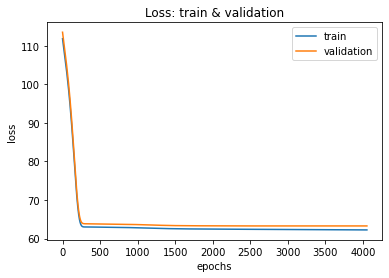

In [32]:
plt.title('Loss: train & validation')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(os.path.join(output_fol, f'{time_tag}_Fig01_LossA.png'))
plt.show()

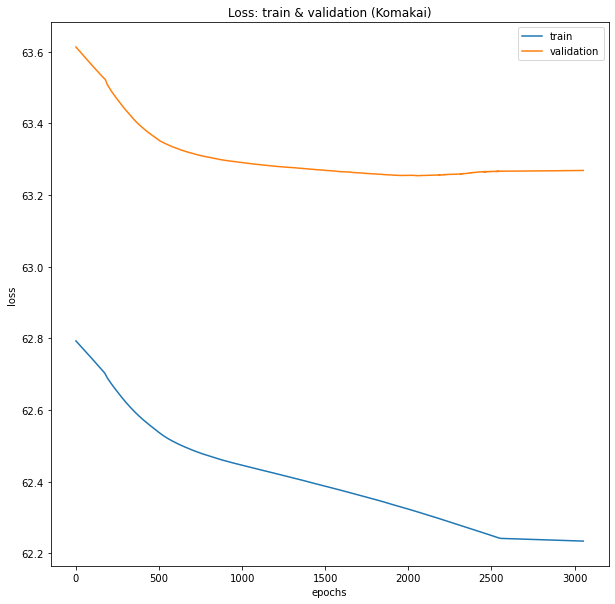

In [33]:
##### Komakai

plt.figure(figsize=(10, 10))
plt.title('Loss: train & validation (Komakai)')
plt.plot(history.history['loss'][1000:], label='train')
plt.plot(history.history['val_loss'][1000:], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(os.path.join(output_fol, f'{time_tag}_Fig02_LossK.png'))
plt.show()

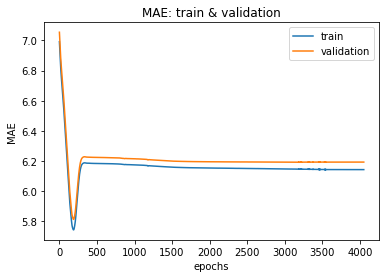

In [34]:
plt.title('MAE: train & validation')
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylabel('MAE')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(os.path.join(output_fol, f'{time_tag}_Fig03_MxA.png'))
plt.show()

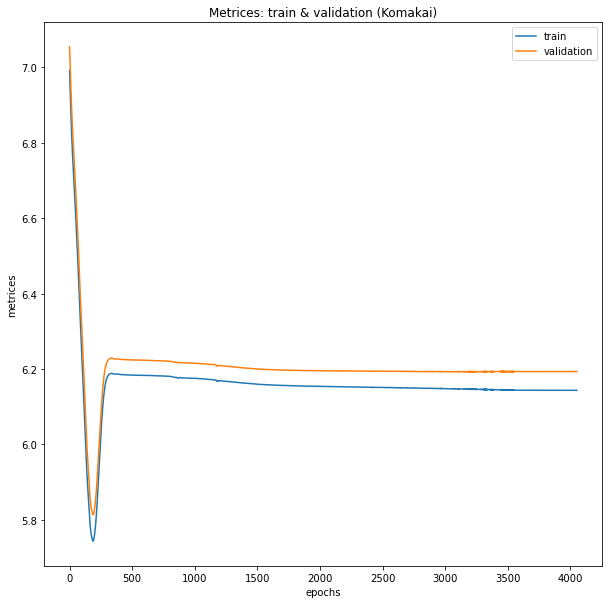

In [35]:
plt.figure(figsize=(10, 10))
plt.title('Metrices: train & validation (Komakai)')
plt.plot(history.history['mean_absolute_error'][-5000:], label='train')
plt.plot(history.history['val_mean_absolute_error'][-5000:], label='validation')
plt.ylabel('metrices')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(os.path.join(output_fol, f'{time_tag}_Fig04_MxA.png'))
plt.show()

In [36]:
x_test = x_test_df.to_numpy()
print(f'Shape of x_test   : {np.shape(x_test)}')
x_predict = model.predict(x_test)
print(f'Shape of x_predict: {np.shape(x_predict)}')

Shape of x_test   : (150000, 73)
Shape of x_predict: (150000, 1)


In [37]:
##### Output

output_df = pd.DataFrame(columns = (['id'] + target_col_li))
output_df['id'] = list(test_df.index)
output_df[target_col_li] = x_predict
#os.mkdir(f'output/{time_tag}')
output_df.to_csv(os.path.join(output_fol, f'{time_tag}_result_{memo}.csv'), index=False)

In [38]:
output_df

,id,loss
0,250000,7.620594
1,250001,6.020957
2,250002,7.644236
3,250003,5.856590
4,250004,7.733532
...,...,...
149995,399995,7.817935
149996,399996,7.149394
149997,399997,6.346754
149998,399998,6.846037


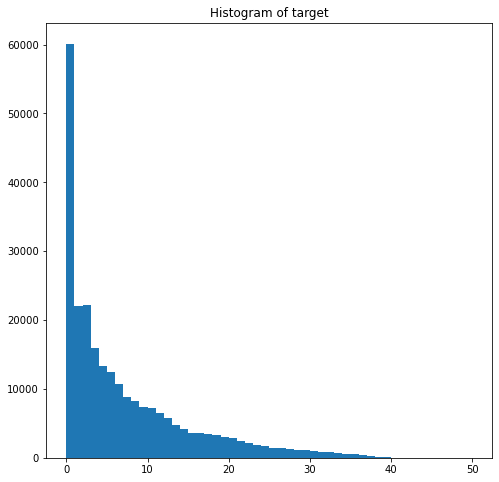

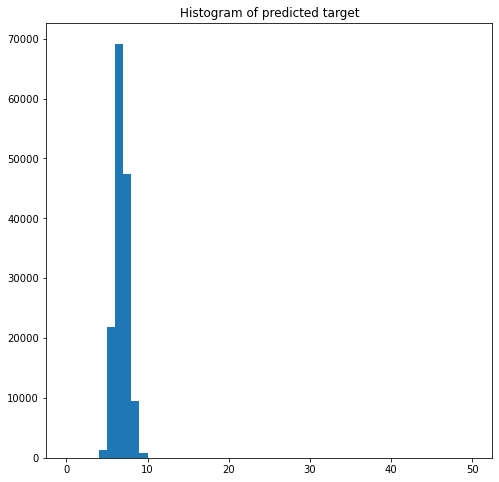

In [39]:
##### Post-check

plt.figure(figsize=(8, 8))
plt.title('Histogram of target')
plt.hist(list(train_df[target_col_li[0]]), bins=50, range=(0, 50))
plt.show()

plt.figure(figsize=(8, 8))
plt.title('Histogram of predicted target')
plt.hist(list(output_df[target_col_li[0]]), bins=50, range=(0, 50))
plt.show()

In [40]:
#####
#####
#####